### Loading Packages and Data

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
ls /share/costeffectiveness/results/vivarium_nih_us_cvd/model_1/nih_us_cvd/alabama/2022_07_29_16_19_31/

__pycache__/   keyspace.yaml             output.hdf
branches.yaml  logs/                     requirements.txt
count_data/    model_specification.yaml  settings.py


In [4]:
ls /share/costeffectiveness/results/vivarium_nih_us_cvd/model_1/nih_us_cvd/alabama/2022_07_29_16_19_31/count_data/

deaths.csv      population.hdf         transition_count.csv  ylds.hdf
deaths.hdf      state_person_time.csv  transition_count.hdf  ylls.csv
population.csv  state_person_time.hdf  ylds.csv              ylls.hdf


In [5]:
sim_results_dir = '/share/costeffectiveness/results/vivarium_nih_us_cvd/model_1/nih_us_cvd/alabama/2022_07_29_16_19_31/count_data/'

### Exploring Data

In [6]:
deaths = pd.read_csv(sim_results_dir + 'deaths.csv')

In [7]:
deaths.head()

,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,age,value
0,0,female,2023,acute_ischemic_stroke,deaths,29,baseline,25_to_29,0
1,1,female,2023,acute_ischemic_stroke,deaths,29,baseline,30_to_34,0
2,2,female,2023,acute_ischemic_stroke,deaths,29,baseline,35_to_39,0
3,3,female,2023,acute_ischemic_stroke,deaths,29,baseline,40_to_44,0
4,4,female,2023,acute_ischemic_stroke,deaths,29,baseline,45_to_49,0


In [8]:
deaths.year.unique()

array([2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033,
       2034, 2035, 2036, 2037, 2038, 2039, 2040])

In [9]:
deaths.cause.unique()

array(['acute_ischemic_stroke', 'chronic_ischemic_stroke', 'other_causes'],
      dtype=object)

In [10]:
deaths.sex.unique()

array(['female', 'male'], dtype=object)

In [11]:
deaths.input_draw.nunique()

10

In [12]:
pop = pd.read_csv(sim_results_dir + 'population.csv')

In [13]:
pop.head()

,Unnamed: 0,measure,input_draw,scenario,value
0,0,total_population,29,baseline,750000
1,1,total_population,232,baseline,750000
2,2,total_population,357,baseline,750000
3,3,total_population,394,baseline,750000
4,4,total_population,602,baseline,750000


In [14]:
pop.loc[pop.measure=="total_population_untracked"].value.sum()

122

In [15]:
pop.measure.unique()

array(['total_population', 'total_population_dead',
       'total_population_living', 'total_population_tracked',
       'total_population_untracked'], dtype=object)

In [16]:
tran = pd.read_csv(sim_results_dir + 'transition_count.csv')

In [17]:
tran.head()

,Unnamed: 0,sex,year,measure,input_draw,scenario,age,transition,disease,value
0,0,female,2023,transition_count,29,baseline,25_to_29,acute_ischemic_stroke_to_chronic_ischemic_stroke,ischemic_stroke,5
1,1,female,2023,transition_count,29,baseline,30_to_34,acute_ischemic_stroke_to_chronic_ischemic_stroke,ischemic_stroke,3
2,2,female,2023,transition_count,29,baseline,35_to_39,acute_ischemic_stroke_to_chronic_ischemic_stroke,ischemic_stroke,7
3,3,female,2023,transition_count,29,baseline,40_to_44,acute_ischemic_stroke_to_chronic_ischemic_stroke,ischemic_stroke,11
4,4,female,2023,transition_count,29,baseline,45_to_49,acute_ischemic_stroke_to_chronic_ischemic_stroke,ischemic_stroke,23


In [18]:
tran.transition.unique()

array(['acute_ischemic_stroke_to_chronic_ischemic_stroke',
       'chronic_ischemic_stroke_to_acute_ischemic_stroke',
       'susceptible_to_ischemic_stroke_to_acute_ischemic_stroke'],
      dtype=object)

### All Cause Mortality Graphs

In [19]:
result_summary = (deaths
                      .groupby(['age', 'sex', 'year'])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,9.866667,0.0,36.100
1,25_to_29,female,2024,7.866667,0.0,28.825
2,25_to_29,female,2025,8.566667,0.0,29.550
3,25_to_29,female,2026,8.100000,0.0,32.100
4,25_to_29,female,2027,8.666667,0.0,30.000


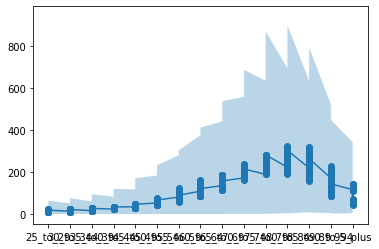

In [20]:
plt.plot(result_summary['age'], result_summary['mean'], marker='o')
plt.fill_between(result_summary['age'], result_summary['2.5%'], result_summary['97.5%'], alpha=.3)

In [21]:
female_2023 = result_summary.loc[(result_summary['sex']=='female') & (result_summary['year']==2023)]
female_2023.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,9.866667,0.0,36.100
36,30_to_34,female,2023,13.800000,0.0,50.825
72,35_to_39,female,2023,15.766667,0.0,59.825
108,40_to_44,female,2023,23.800000,0.0,82.025
144,45_to_49,female,2023,33.866667,0.0,117.275


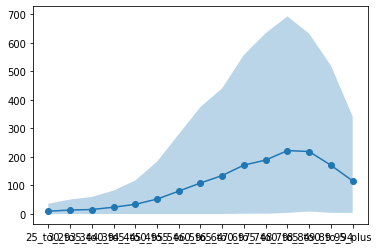

In [22]:
plt.plot(female_2023['age'], female_2023['mean'], marker='o')
plt.fill_between(female_2023['age'], female_2023['2.5%'], female_2023['97.5%'], alpha=.3)

#### All Cause Mortality Graph with Rate

In [104]:
per_time = pd.read_csv(sim_results_dir + 'state_person_time.csv')
per_time = per_time.rename(columns = {'value':'ptvalue'})
per_time = per_time.groupby(['age', 'sex', 'year', 'input_draw']).ptvalue.sum().reset_index()

per_time.head()

,age,sex,year,input_draw,ptvalue
0,25_to_29,female,2023,29,29969.774127
1,25_to_29,female,2023,232,30072.344969
2,25_to_29,female,2023,357,30068.971937
3,25_to_29,female,2023,394,30343.567420
4,25_to_29,female,2023,602,30302.017796


In [108]:
results_rate = deaths.groupby(['age', 'sex', 'year', 'input_draw']).value.sum().reset_index()
print(len(per_time))

5400


In [111]:
results_rate = pd.concat([results_rate, per_time.ptvalue], axis=1)
results_rate.head()

,age,sex,year,input_draw,value,ptvalue
0,25_to_29,female,2023,29,31,29969.774127
1,25_to_29,female,2023,232,34,30072.344969
2,25_to_29,female,2023,357,26,30068.971937
3,25_to_29,female,2023,394,25,30343.567420
4,25_to_29,female,2023,602,25,30302.017796


In [114]:
results_rate['mean_rate'] = results_rate['value'] / results_rate['ptvalue']
results_rate.head()

,age,sex,year,input_draw,value,ptvalue,mean_rate
0,25_to_29,female,2023,29,31,29969.774127,0.001034
1,25_to_29,female,2023,232,34,30072.344969,0.001131
2,25_to_29,female,2023,357,26,30068.971937,0.000865
3,25_to_29,female,2023,394,25,30343.567420,0.000824
4,25_to_29,female,2023,602,25,30302.017796,0.000825


In [115]:
result_summary = (results_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000981,0.000824,0.001259
1,25_to_29,female,2024,0.000848,0.000550,0.001099
2,25_to_29,female,2025,0.000932,0.000752,0.001101
3,25_to_29,female,2026,0.000892,0.000534,0.001246
4,25_to_29,female,2027,0.000965,0.000590,0.001114


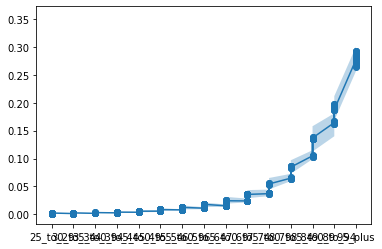

In [116]:
plt.plot(result_summary['age'], result_summary['mean'], marker='o')
plt.fill_between(result_summary['age'], result_summary['2.5%'], result_summary['97.5%'], alpha=.3)

In [118]:
male_2037 = result_summary.loc[(result_summary['sex']=='male') & (result_summary['year']==2037)]
male_2037.head()

,age,sex,year,mean,2.5%,97.5%
32,25_to_29,male,2037,0.001997,0.001588,0.002416
68,30_to_34,male,2037,0.002415,0.001617,0.002899
104,35_to_39,male,2037,0.002947,0.002434,0.003421
140,40_to_44,male,2037,0.003693,0.002977,0.004238
176,45_to_49,male,2037,0.005454,0.004200,0.006572


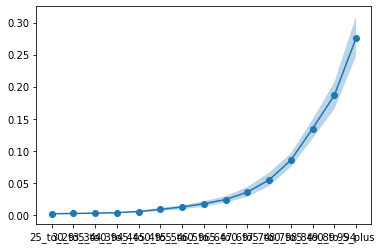

In [119]:
plt.plot(male_2037['age'], male_2037['mean'], marker='o')
plt.fill_between(male_2037['age'], male_2037['2.5%'], male_2037['97.5%'], alpha=.3)

### Cause Specific Mortality Graphs
#### Acute Stroke

In [29]:
working = (deaths
               .groupby(['age', 'sex', 'year', 'cause'])
               .value.describe(percentiles=[.025, .975])
               .filter(['mean', '2.5%', '97.5%'])
               .reset_index())

acute = working.loc[(working['cause'] == 'acute_ischemic_stroke')].reset_index()

acute.head()

,index,age,sex,year,cause,mean,2.5%,97.5%
0,0,25_to_29,female,2023,acute_ischemic_stroke,0.1,0.0,0.775
1,3,25_to_29,female,2024,acute_ischemic_stroke,0.2,0.0,1.000
2,6,25_to_29,female,2025,acute_ischemic_stroke,0.0,0.0,0.000
3,9,25_to_29,female,2026,acute_ischemic_stroke,0.1,0.0,0.775
4,12,25_to_29,female,2027,acute_ischemic_stroke,0.1,0.0,0.775


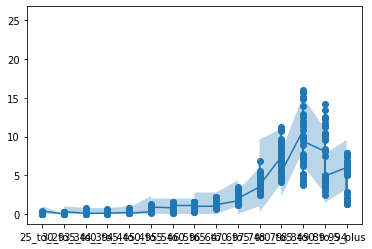

In [30]:
plt.plot(acute['age'], acute['mean'], marker='o')
plt.fill_between(acute['age'], acute['2.5%'], acute['97.5%'], alpha=.3)

In [31]:
female_2023_acute = acute.loc[(acute['sex']=='female') & (acute['year']==2023)]
female_2023_acute.head()

,index,age,sex,year,cause,mean,2.5%,97.5%
0,0,25_to_29,female,2023,acute_ischemic_stroke,0.1,0.0,0.775
36,108,30_to_34,female,2023,acute_ischemic_stroke,0.0,0.0,0.000
72,216,35_to_39,female,2023,acute_ischemic_stroke,0.1,0.0,0.775
108,324,40_to_44,female,2023,acute_ischemic_stroke,0.1,0.0,0.775
144,432,45_to_49,female,2023,acute_ischemic_stroke,0.2,0.0,1.000


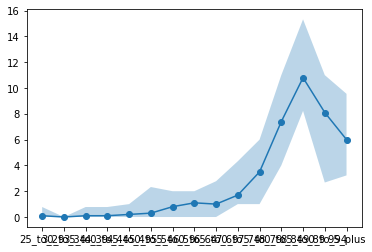

In [32]:
plt.plot(female_2023_acute['age'], female_2023_acute['mean'], marker='o')
plt.fill_between(female_2023_acute['age'], female_2023_acute['2.5%'], female_2023_acute['97.5%'], alpha=.3)

In [178]:
death_rate = deaths.groupby(['age', 'sex', 'year', 'input_draw', 'cause']).value.sum().reset_index()
acute_rate = death_rate.loc[(death_rate['cause'] == 'acute_ischemic_stroke')].reset_index()
acute_rate.head()

,index,age,sex,year,input_draw,cause,value
0,0,25_to_29,female,2023,29,acute_ischemic_stroke,0
1,3,25_to_29,female,2023,232,acute_ischemic_stroke,0
2,6,25_to_29,female,2023,357,acute_ischemic_stroke,0
3,9,25_to_29,female,2023,394,acute_ischemic_stroke,0
4,12,25_to_29,female,2023,602,acute_ischemic_stroke,0


In [129]:
per_time.ptvalue.head()
len(per_time.ptvalue)

5400

In [138]:
acute_rate_2 = pd.concat([acute_rate, per_time.ptvalue], axis=1)
acute_rate_2['mean_rate'] = acute_rate_2['value'] / acute_rate_2['ptvalue']
acute_rate_summary = (acute_rate_2
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000003,0.0,0.000026
1,25_to_29,female,2024,0.000007,0.0,0.000036
2,25_to_29,female,2025,0.000000,0.0,0.000000
3,25_to_29,female,2026,0.000004,0.0,0.000029
4,25_to_29,female,2027,0.000004,0.0,0.000029


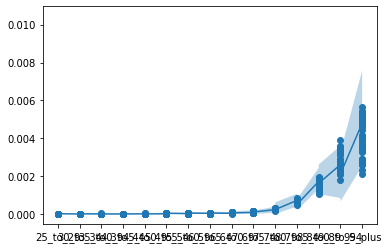

In [140]:
plt.plot(acute_rate_summary['age'], acute_rate_summary['mean'], marker='o')
plt.fill_between(acute_rate_summary['age'], acute_rate_summary['2.5%'], acute_rate_summary['97.5%'], alpha=.3)

In [143]:
male_2028_acute_rate = acute_rate_summary.loc[(acute_rate_summary['sex']=='male') & (acute_rate_summary['year']==2028)]
male_2028_acute_rate.head()

,age,sex,year,mean,2.5%,97.5%
23,25_to_29,male,2028,0.000000,0.0,0.000000
59,30_to_34,male,2028,0.000007,0.0,0.000036
95,35_to_39,male,2028,0.000004,0.0,0.000030
131,40_to_44,male,2028,0.000004,0.0,0.000031
167,45_to_49,male,2028,0.000013,0.0,0.000076


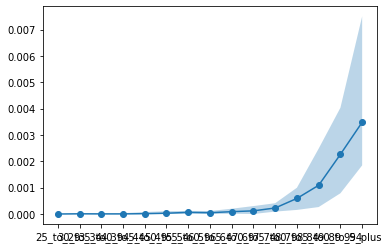

In [144]:
plt.plot(male_2028_acute_rate['age'], male_2028_acute_rate['mean'], marker='o')
plt.fill_between(male_2028_acute_rate['age'], male_2028_acute_rate['2.5%'], male_2028_acute_rate['97.5%'], alpha=.3)

#### Chronic Stroke

In [186]:
chronic_rate = death_rate.loc[(death_rate['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate = pd.concat([chronic_rate, per_time.ptvalue], axis=1)
chronic_rate['mean_rate'] = chronic_rate['value'] / chronic_rate['ptvalue']
chronic_rate = (chronic_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

chronic_rate.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.0,0.0,0.0
1,25_to_29,female,2024,0.0,0.0,0.0
2,25_to_29,female,2025,0.0,0.0,0.0
3,25_to_29,female,2026,0.0,0.0,0.0
4,25_to_29,female,2027,0.0,0.0,0.0


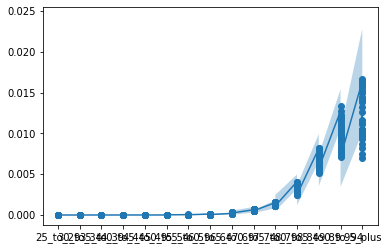

In [187]:
plt.plot(chronic_rate['age'], chronic_rate['mean'], marker='o')
plt.fill_between(chronic_rate['age'], chronic_rate['2.5%'], chronic_rate['97.5%'], alpha=.3)

In [188]:
male_2040_chronic_rate = chronic_rate.loc[(chronic_rate['sex']=='male') & (chronic_rate['year']==2040)]
male_2040_chronic_rate.head()

,age,sex,year,mean,2.5%,97.5%
35,25_to_29,male,2040,0.0,0.0,0.0
71,30_to_34,male,2040,0.0,0.0,0.0
107,35_to_39,male,2040,0.0,0.0,0.0
143,40_to_44,male,2040,0.0,0.0,0.0
179,45_to_49,male,2040,0.0,0.0,0.0


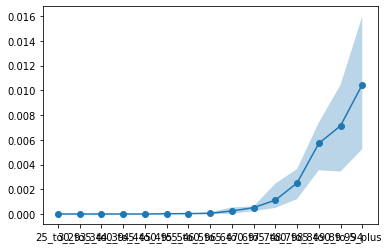

In [189]:
plt.plot(male_2040_chronic_rate['age'], male_2040_chronic_rate['mean'], marker='o')
plt.fill_between(male_2040_chronic_rate['age'], male_2040_chronic_rate['2.5%'], male_2040_chronic_rate['97.5%'], alpha=.3)

### Prevalence

In [37]:
prev = (per_time
            .groupby(['age', 'sex', 'year', 'state'])
            .value.describe(percentiles=[.025, .975])
            .filter(['mean', '2.5%', '97.5%'])
            .reset_index())

prev.head()

,age,sex,year,state,mean,2.5%,97.5%
0,25_to_29,female,2023,acute_ischemic_stroke,0.260643,0.076660,0.638193
1,25_to_29,female,2023,chronic_ischemic_stroke,154.469541,134.576318,171.244627
2,25_to_29,female,2023,susceptible_to_ischemic_stroke,30029.093498,29832.296235,30171.767009
3,25_to_29,female,2024,acute_ischemic_stroke,0.360301,0.076660,0.808761
4,25_to_29,female,2024,chronic_ischemic_stroke,141.851335,123.769199,165.742368


In [38]:
prev_pivot = pd.pivot(prev, 
columns = 'state',
index = ['age', 'sex', 'year'],
values = ['mean', '2.5%', '97.5%'])
prev_pivot.head()

mean                          \
state                acute_ischemic_stroke chronic_ischemic_stroke   
age      sex    year                                                 
25_to_29 female 2023              0.260643              154.469541   
                2024              0.360301              141.851335   
                2025              0.237645              140.279808   
                2026              0.260643              134.783299   
                2027              0.222313              128.267214   

                                                                     2.5%  \
state                susceptible_to_ischemic_stroke acute_ischemic_stroke   
age      sex    year                                                        
25_to_29 female 2023                   30029.093498              0.076660   
                2024                   27698.619576              0.076660   
                2025                   27424.269405              0.017248   
                2026                   27104.935250              0.076660   
                2027                   26812.547023              0.000000   

                                                                             \
state                chronic_ischemic_stroke susceptible_to_ischemic_stroke   
age      sex    year                                                          
25_to_29 female 2023              134.576318                   29832.296235   
                2024              123.769199                   27410.507050   
                2025              115.181383                   26996.264203   
                2026              102.461602                   26784.755921   
                2027               97.402053                   26625.452977   

                                     97.5%                          \
state                acute_ischemic_stroke chronic_ischemic_stroke   
age      sex    year                                                 
25_to_29 female 2023              0.638193              171.244627   
                2024              0.808761              165.742368   
                2025              0.502122              169.464203   
                2026              0.519370              154.532786   
                2027              0.732101              143.054894   

                                                     
state                susceptible_to_ischemic_stroke  
age      sex    year                                 
25_to_29 female 2023                   30171.767009  
                2024                   27892.611088  
                2025                   27757.751129  
                2026                   27392.652977  
                2027                   26998.450924

### Incidence of First Time Acute Ischemic Stroke

In [39]:
tran_sum = (tran
                 .groupby(['age', 'sex', 'year', 'transition'])
                 .value.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_sum = tran_sum.loc[(tran_sum['transition'] == 'susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_sum.head()

,index,age,sex,year,transition,mean,2.5%,97.5%
0,2,25_to_29,female,2023,susceptible_to_ischemic_stroke_to_acute_ischem...,3.4,1.000,8.325
1,5,25_to_29,female,2024,susceptible_to_ischemic_stroke_to_acute_ischem...,5.0,1.000,9.550
2,8,25_to_29,female,2025,susceptible_to_ischemic_stroke_to_acute_ischem...,3.0,0.225,6.775
3,11,25_to_29,female,2026,susceptible_to_ischemic_stroke_to_acute_ischem...,3.3,1.000,6.775
4,14,25_to_29,female,2027,susceptible_to_ischemic_stroke_to_acute_ischem...,3.1,0.000,10.325


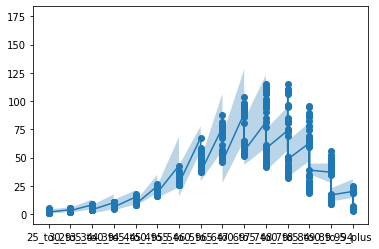

In [42]:
plt.plot(tran_sum['age'], tran_sum['mean'], marker='o')
plt.fill_between(tran_sum['age'], tran_sum['2.5%'], tran_sum['97.5%'], alpha=.3)

In [43]:
per_time_inc = per_time.loc[(per_time['state'] == 'susceptible_to_ischemic_stroke')].reset_index()
per_time_inc.head()

,index,Unnamed: 0,sex,year,measure,input_draw,scenario,age,state,disease,value
0,30,30,female,2023,state_person_time,29,baseline,25_to_29,susceptible_to_ischemic_stroke,ischemic_stroke,29808.941821
1,31,31,female,2023,state_person_time,29,baseline,30_to_34,susceptible_to_ischemic_stroke,ischemic_stroke,28718.225873
2,32,32,female,2023,state_person_time,29,baseline,35_to_39,susceptible_to_ischemic_stroke,ischemic_stroke,28277.585216
3,33,33,female,2023,state_person_time,29,baseline,40_to_44,susceptible_to_ischemic_stroke,ischemic_stroke,26599.118412
4,34,34,female,2023,state_person_time,29,baseline,45_to_49,susceptible_to_ischemic_stroke,ischemic_stroke,27581.590691


In [157]:
per_time_inc = (per_time.groupby(['age', 'sex', 'year', 'input_draw']).ptvalue.sum().reset_index())

per_time_inc.head()

,age,sex,year,input_draw,ptvalue
0,25_to_29,female,2023,29,29969.774127
1,25_to_29,female,2023,232,30072.344969
2,25_to_29,female,2023,357,30068.971937
3,25_to_29,female,2023,394,30343.567420
4,25_to_29,female,2023,602,30302.017796


In [168]:
tran = tran.groupby(['age', 'sex', 'year', 'transition', 'input_draw']).value.sum().reset_index()
tran = tran.loc[(tran['transition'] == 'susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_rate = pd.concat([tran, per_time_inc.ptvalue], axis=1)
tran_rate['rate']= tran_rate['value'] / tran_rate['ptvalue']
tran_rate = (tran_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000113,0.000033,0.000276
1,25_to_29,female,2024,0.000180,0.000036,0.000344
2,25_to_29,female,2025,0.000109,0.000008,0.000245
3,25_to_29,female,2026,0.000121,0.000036,0.000249
4,25_to_29,female,2027,0.000115,0.000000,0.000384


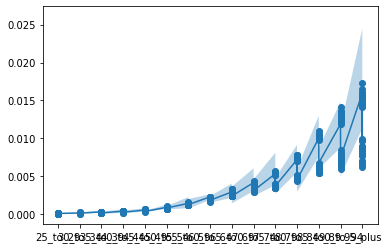

In [169]:
plt.plot(tran_rate['age'], tran_rate['mean'], marker='o')
plt.fill_between(tran_rate['age'], tran_rate['2.5%'], tran_rate['97.5%'], alpha=.3)

In [170]:
female_2040_tran_rate = tran_rate.loc[(tran_rate['sex']=='female') & (tran_rate['year']==2040)]
female_2040_tran_rate.head()

,age,sex,year,mean,2.5%,97.5%
17,25_to_29,female,2040,0.000115,0.000009,0.000230
53,30_to_34,female,2040,0.000161,0.000038,0.000375
89,35_to_39,female,2040,0.000217,0.000076,0.000372
125,40_to_44,female,2040,0.000386,0.000267,0.000620
161,45_to_49,female,2040,0.000508,0.000281,0.000705


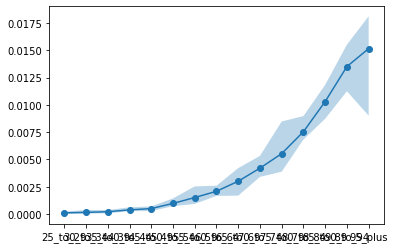

In [171]:
plt.plot(female_2040_tran_rate['age'], female_2040_tran_rate['mean'], marker='o')
plt.fill_between(female_2040_tran_rate['age'], female_2040_tran_rate['2.5%'], female_2040_tran_rate['97.5%'], alpha=.3)

In [173]:
female_6064_tran_rate = tran_rate.loc[(tran_rate['sex']=='female') & (tran_rate['age']=='60_to_64')]
female_6064_tran_rate.head()

,age,sex,year,mean,2.5%,97.5%
252,60_to_64,female,2023,0.002265,0.001860,0.002610
253,60_to_64,female,2024,0.001993,0.001544,0.002785
254,60_to_64,female,2025,0.002022,0.001662,0.002552
255,60_to_64,female,2026,0.001989,0.001407,0.002487
256,60_to_64,female,2027,0.002124,0.001863,0.002452


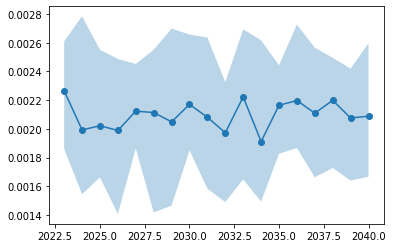

In [175]:
plt.plot(female_6064_tran_rate['year'], female_6064_tran_rate['mean'], marker='o')
plt.fill_between(female_6064_tran_rate['year'], female_6064_tran_rate['2.5%'], female_6064_tran_rate['97.5%'], alpha=.3)

### Artifacts

In [190]:
ls /mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/

alabama.hdf


In [191]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [192]:
art_pop = art.load('population.structure').reset_index()
art_pop

,location,sex,age_start,age_end,year_start,year_end,value
0,Alabama,Female,25.0,30.0,2019,2020,171101.787730
1,Alabama,Female,30.0,35.0,2019,2020,162707.127245
2,Alabama,Female,35.0,40.0,2019,2020,160738.561697
3,Alabama,Female,40.0,45.0,2019,2020,151811.937430
...,...,...,...,...,...,...,...
26,Alabama,Male,80.0,85.0,2019,2020,39717.256293
27,Alabama,Male,85.0,90.0,2019,2020,20451.497955
28,Alabama,Male,90.0,95.0,2019,2020,8076.996387
29,Alabama,Male,95.0,125.0,2019,2020,2550.613480


In [193]:
art.keys

['metadata.keyspace',
 'metadata.locations',
 'population.location',
 'population.structure',
 'population.age_bins',
 'population.demographic_dimensions',
 'population.theoretical_minimum_risk_life_expectancy',
 'cause.all_causes.cause_specific_mortality_rate',
 'sequela.acute_ischemic_stroke.prevalence',
 'sequela.chronic_ischemic_stroke.prevalence',
 'cause.ischemic_stroke.incidence_rate',
 'sequela.acute_ischemic_stroke.disability_weight',
 'sequela.chronic_ischemic_stroke.disability_weight',
 'sequela.acute_ischemic_stroke.excess_mortality_rate',
 'sequela.chronic_ischemic_stroke.excess_mortality_rate',
 'cause.ischemic_stroke.cause_specific_mortality_rate',
 'cause.ischemic_stroke.restrictions',
 'cause.acute_myocardial_infarction.prevalence',
 'cause.post_myocardial_infarction.prevalence',
 'cause.acute_myocardial_infarction.incidence_rate',
 'cause.post_myocardial_infarction.incidence_rate',
 'cause.acute_myocardial_infarction.disability_weight',
 'cause.post_myocardial_infarct

In [218]:
art_mort = art.load('sequela.acute_ischemic_stroke.excess_mortality_rate').reset_index()
art_mort.head()

,sex,age_start,age_end,year_start,year_end,draw_0,draw_1,draw_2,draw_3,draw_4,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,Female,25.0,30.0,2019,2020,0.31588,0.40003,0.32045,0.38893,0.24140,...,0.27915,0.29902,0.33340,0.28170,0.45043,0.26388,0.31837,0.28815,0.23798,0.20685
1,Female,30.0,35.0,2019,2020,0.30193,0.33175,0.28828,0.37140,0.24475,...,0.27680,0.29742,0.35445,0.23455,0.42553,0.22783,0.26775,0.28548,0.25033,0.25325
2,Female,35.0,40.0,2019,2020,0.28018,0.29485,0.27522,0.29580,0.32445,...,0.29240,0.29728,0.32355,0.24025,0.35158,0.27568,0.30525,0.40163,0.30818,0.44195
3,Female,40.0,45.0,2019,2020,0.24315,0.27495,0.29525,0.26428,0.35000,...,0.28105,0.31522,0.29495,0.24098,0.31315,0.28515,0.32320,0.41060,0.31078,0.45695
4,Female,45.0,50.0,2019,2020,0.19085,0.27205,0.34835,0.27682,0.32140,...,0.24275,0.35128,0.26865,0.23673,0.31025,0.25625,0.32160,0.31240,0.25812,0.29825


In [209]:
def load_artifact_data(cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['alabama']: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load('cause.' + cause + '.' + measure)
        
        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
        data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

In [213]:
art_acmr = load_artifact_data('all_causes', 'cause_specific_mortality_rate')
art_acmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_acmr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000950,0.000706,0.001237,Alabama,cause_specific_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.001364,0.001029,0.001755,Alabama,cause_specific_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.001697,0.001285,0.002179,Alabama,cause_specific_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.002592,0.001978,0.003305,Alabama,cause_specific_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.003660,0.002792,0.004668,Alabama,cause_specific_mortality_rate,45_to_49


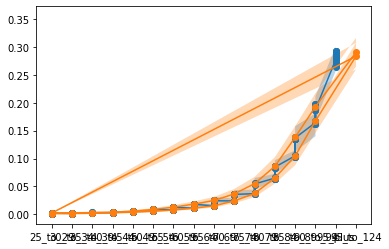

In [214]:
plt.plot(result_summary['age'], result_summary['mean'], marker='o')
plt.fill_between(result_summary['age'], result_summary['2.5%'], result_summary['97.5%'], alpha=.3)
plt.plot(art_acmr['age_group'], art_acmr['mean'], marker='o')
plt.fill_between(art_acmr['age_group'], art_acmr['2.5%'], art_acmr['97.5%'], alpha=.3)

In [215]:
art_emr = load_artifact_data('ischemic_stroke', 'cause_specific_mortality_rate')
art_emr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_emr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000002,0.000001,0.000003,Alabama,cause_specific_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000004,0.000002,0.000007,Alabama,cause_specific_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000006,0.000003,0.000009,Alabama,cause_specific_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000011,0.000007,0.000016,Alabama,cause_specific_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000017,0.000011,0.000026,Alabama,cause_specific_mortality_rate,45_to_49


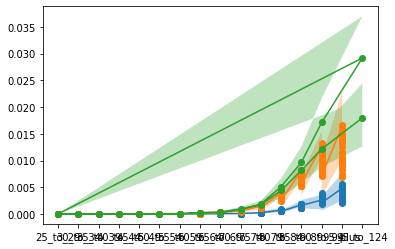

In [219]:
plt.plot(acute_rate_summary['age'], acute_rate_summary['mean'], marker='o')
plt.fill_between(acute_rate_summary['age'], acute_rate_summary['2.5%'], acute_rate_summary['97.5%'], alpha=.3)
plt.plot(chronic_rate['age'], chronic_rate['mean'], marker='o')
plt.fill_between(chronic_rate['age'], chronic_rate['2.5%'], chronic_rate['97.5%'], alpha=.3)
plt.plot(art_emr['age_group'], art_emr['mean'], marker='o')
plt.fill_between(art_emr['age_group'], art_emr['2.5%'], art_emr['97.5%'], alpha=.3)

### GBD Comparison